# Свертка изображений

Основной инструмент работы в области компьютерного зрения — свёртки. Познакомившись со свертками в CNN будет проще понять концепт сверток в GNN. В этом ноутбуке я применяю константные свёртки к изображению

In [1]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm

warnings.filterwarnings("ignore")
%matplotlib inline

## Работа с картинками с помощью **NumPy** и **MatplotLib**

### Подгрузим изображение

Формат картинки: JPEG; размер: (640, 427); цветовой режим: RGB


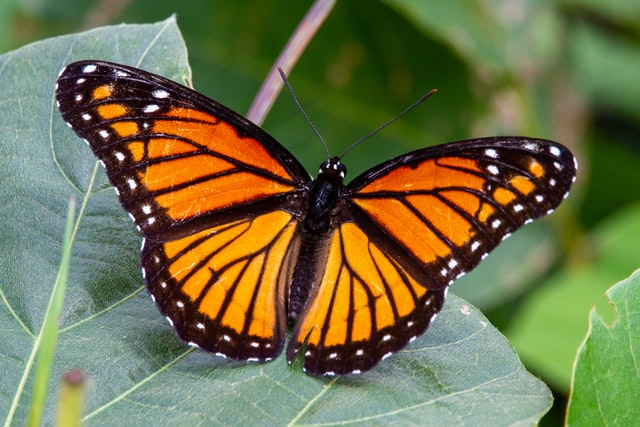

In [2]:
from PIL import Image

img = Image.open("data/butterfly.jpg")
print(f"Формат картинки: {img.format}; размер: {img.size}; цветовой режим: {img.mode}")
img

### Матричное представление изображения

Цветное изображение состоит из трех числовых матриц (то бишь, трехмерного тензора), называемых каналами. 

Каждая матрица соответствует одному из трех базовых цветов: <span style="color:red">красному</span>, <span style="color:green">зеленому</span> и <span style="color:blue">синему</span>.

Размерность массива изображения: (427, 640, 3)


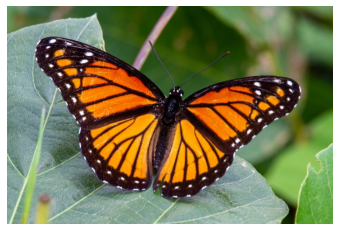

In [3]:
# преобразуем изображение в массив
img_matrix = np.array(img)

# (высота, ширина, число каналов)
print(f"Размерность массива изображения: {img_matrix.shape}")

plt.imshow(img_matrix)
plt.axis(False)
plt.show()

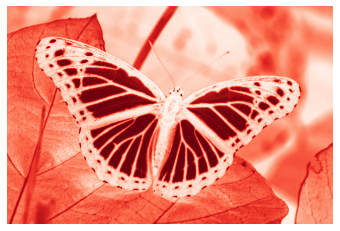

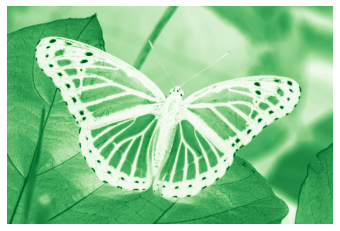

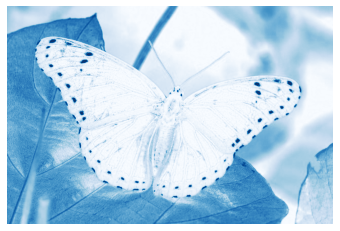

In [4]:
# посмотрим на все каналы изображения отдельно
plt.imshow(img_matrix[:, :, 0], cmap=cm.Reds)
plt.axis(False)
plt.show()

plt.imshow(img_matrix[:, :, 1], cmap=cm.Greens)
plt.axis(False)
plt.show()

plt.imshow(img_matrix[:, :, 2], cmap=cm.Blues)
plt.axis(False)
plt.show()

## Как работают константные свёртки у изображений

### Класс torch.nn.Conv2d

In [5]:
import torch.nn as nn

In [6]:
nn.Conv2d

torch.nn.modules.conv.Conv2d

В изветсной библиотеке **PyTorch** свёрточный слой представлен в модуле `torch.nn` классом [`Conv2d`](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) с основными параметрами:
- `in_channels`: количество каналов на входе
- `out_channels`: количество каналов на выходе
- `kernel_size`: размер ядра 
- `stride`: шаг 
- `padding`: паддинг

#### `kernel_size`

**Размер ядра**. `int`, если ядро квадратное и кортеж из двух чисел, если ядро прямоугольное. Задает размер фильтра, с которым производится свёртка изображения.

**`kernel_size=3`**

![no_padding_no_strides.gif](data/no_padding_no_strides.gif)

#### `stride`

**Шаг**. Задает шаг, в пикселях, на который сдвигается фильтр. `int`, если по горизонтали и вертикали сдвигается на одно и то же число. Кортеж из двух чисел, если сдвиги разные.

**`stride=2`**

![no_padding_strides.gif](data/no_padding_strides.gif)

#### `padding`

**Паддинг**. Количество пикселей, которыми дополняется изображение. Аналогично шагу и размеру ядра, может быть, как `int`, так и кортежем из двух чисел.

**`padding=1`**

![same_padding_no_strides.gif](data/same_padding_no_strides.gif)

### Свёртка изображений

Свертки детектируют **паттерны на картинках** – цвета и сочетания цветов, небольшие объекты. Обычно значения свертки являются обучаемыми параметрами нейрости. Однако существуют "готовые" свертки, настроенные на определенные паттерны.

Например, оператор _Собеля_ используется для детекции границ на изображении. 

Вместо класса `torch.nn.Conv2d`, возьмём соответствующую функцию из модуля `torch.nn.functional`. 

In [7]:
import torch

# В этом модуле примерно все те же самые операторы, что и в `torch.nn`,
# но только представлениы они не в виде классов, а виде функций.
from torch.nn.functional import conv2d

In [8]:
conv2d

<function torch._VariableFunctionsClass.conv2d>

Преобразуем картинку в тензор и переставим размерности в порядке `(batch_size, n_channels, height, width)`, который принят в **PyTorch**.

In [9]:
img_matrix.shape

(427, 640, 3)

In [10]:
img_tensor = torch.tensor(img_matrix, dtype=torch.float)
img_tensor = img_tensor.permute(2, 0, 1).unsqueeze(0)
img_tensor.size()

torch.Size([1, 3, 427, 640])

Зададим оператор Собеля для выделения горизонтальных границ на каждый канал изображения

In [12]:
sobel_hor = [
    [-1, -2, -1], 
    [0, 0, 0], 
    [1, 2, 1]
]

kernel = [[sobel_hor, sobel_hor, sobel_hor]]
kernel = torch.tensor(kernel, dtype=torch.float)
kernel.size()

torch.Size([1, 3, 3, 3])

Свернём картинку с подготовленным ядром свёртки

In [13]:
img_conv_hor = conv2d(img_tensor, kernel)
img_conv_hor = img_conv_hor.permute(0, 2, 3, 1)
img_conv_hor.size()

torch.Size([1, 425, 638, 1])

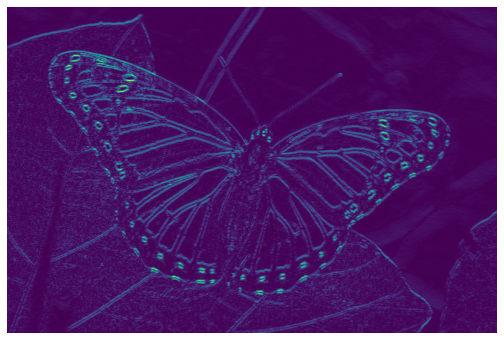

In [14]:
plt.figure(figsize=(1.5 * 7, 1.5 * 4))
plt.imshow(torch.abs(img_conv_hor[0, :, :, 0]))
plt.axis(False)
plt.show()

Проделаем то же самое для детектирования вертикальных границ

In [15]:
sobel_ver = [
    [-1, 0, 1], 
    [-2, 0, 2], 
    [-1, 0, 1]
]

kernel = [[sobel_ver, sobel_ver, sobel_ver]]
kernel = torch.tensor(kernel, dtype=torch.float)

img_conv_ver = conv2d(img_tensor, kernel)

img_conv_ver = img_conv_ver.permute(0, 2, 3, 1)
img_conv_ver.size()

torch.Size([1, 425, 638, 1])

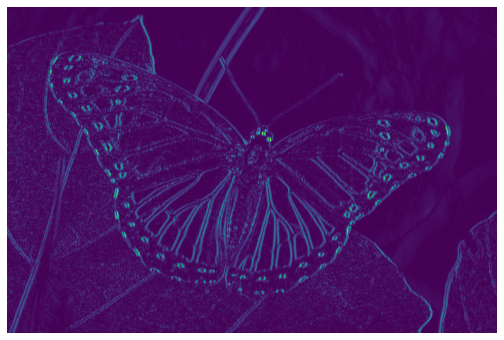

In [16]:
plt.figure(figsize=(1.5 * 7, 1.5 * 4))
plt.imshow(torch.abs(img_conv_ver[0, :, :, 0]))
plt.axis(False)
plt.show()

Наконец, объединим два изображения

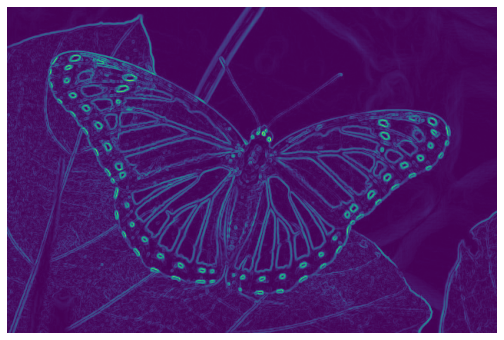

In [17]:
img_conv = torch.sqrt(img_conv_ver**2 + img_conv_hor**2)

plt.figure(figsize=(1.5 * 7, 1.5 * 4))
plt.imshow(img_conv[0, :, :, 0])
plt.axis(False)
plt.show()